# Проект "Телеком". Прогнозирование оттока клиентов.
## Постановка задачи
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

## План работы

Мы предполагаем, что целевой признак - это наличие даты в столбце `EndDate` файла `contract.csv`.

Мы предполагаем также, что на целевой признак может влиять общая длительность контракта (например, старые клиенты могут быть более лояльны, чем новые).

Мы также будем считать лишним данным общую сумму платежей (если есть ежемесячная сумма и длительность контракта).

### Разведочный анализ данных:
- изучим данные методом info();

- проверим данные на дубликаты;

### Исследовательский анализ данных:
- проверим данные на аномалии;

- выделим отдельный целевой признак (столбец `gone`, который будет равняться нулю, если в столбце `EndDate` стоит значение `No` и 1 в остальных случаях);

- выделим признак, равный длительности контракта в месяцах (для длящихся контрактов будем считать окончанием контракта 1 февраля 2020 года);

- объединим таблицы  contract и personal методом merge с параметром how='inner', дополнительно объединив их с таблицами internet и phone с параметром how='outer';

- удалим столцы `BeginDate`, `EndDate`, `TotalCharges`;

- проведем корреляционный анализ данных, в результате чего, возможно, удалим ещё некоторые признаки как не влияющие на целевой;

- изменим тип данных там, где это необходимо;


### Подготовка данных для построения модели:

- разобьем выборку на тренировочную и тестовую в соотношении 75:25;

- заполним пропуски в тренировочной и тестовой выборках модовым значением, вычисленным по тренировочной выборке (если речь об услуге подключения к нескольким линиям/типе интернет-связи), либо значением `No`, если речь идёт о дополнительных интернет-услугах;

- закодируем категориальные признаки;

- масштабируем количественные признаки (для применения логистической регрессии).

### Построение модели
Поскольку мы имеем дело с задачей классификации, то будем использовать соответствующие известные нам модели:

- случайный лес;

- дерево решений;

- логистическая регрессия;

- стохастический градиентный спуск SGDClassifier;

- бустинг с помощью CatBoostClassifier;

- бустинг с помощью LGBMClassifier;

Кроме того, там, где это возможно, и не слишком удлиняет время вычислений (в простых моделях), мы будем использовать автоматический подбор гиперпараметров с помощью GreedSearchCV. Также мы, возможно, будем использовать вспомогательные методы улучшения метрики качества, такие как подбор порога классификации.

Мы подберем лучшие гиперпараметры на тренировочных данных; используя кросс-валидацию, выберем лучшую модель, на которой проведем финальное тестирование.

### Метрика качества

Поскольку нам требуется, с одной стороны, не пропустить пользователей, которые хотят уйти, а с другой стороны, не выявить лишних (предоставление скидок и промокодов снижает прибыль компании), то требуется использовать метрику, которая сочетает требования к TPR (true positive rate) и FPR (false positive rate). К этим метрикам относится `roc_auc_score`, будем использовать ее. В качестве вспомогательной метрики будем использовать также `accuracy_score`.











## Разведочный анализ данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import phik
from phik.report import plot_correlation_matrix
from phik import report
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
except:
    contract = pd.read_csv('C:\\YP\\contract.csv')
try:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
except:
    internet = pd.read_csv('C:\\YP\\internet.csv')
try:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
except:
    personal = pd.read_csv('C:\\YP\\personal.csv')
try:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    phone = pd.read_csv('C:\\YP\\phone.csv')

Файл `contract.csv` содержит информацию о 7043 договорах, а именно:
- ID клиента
- дату заключения договора
- дату окончания договора, либо слово 'No' в том случае, если договор активен на 1 февраля 2020 года
- дополнительные сведения о договоре (электронные чеки, способ оплаты,  ежемесячные платежи, общая сумма платежей)

**Целевым признаком является дата окончания договора** в столбце `EndDate` файла `contract.csv` (если она проставлена, значит, клиент ушёл). 

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract.duplicated().sum()

0

In [6]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Файл `personal.csv` содержит информацию о 7043 клиентах, влючая:
- ID клиента
- сведения о клиенте (является ли клиент пенсионером, информацию о партнёре и иждивенцах)

Оба файла не содержат пропусков и дубликатов. Объединив данные, содержащиеся в этих файлах по полю `CustomerID` с помощью метода merge с параметром how='inner' (предполагающим пересечение индексов - даже если во второй таблице есть индексы, которых нет в первой, нам они не нужны, т.к. нет целевого признака), мы должны получить таблицу из 7043 строк. 

In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
personal.duplicated().sum()

0

Файл `internet.csv` содержит информацию о 5517 договорах, заключенных на интернет-услуги, в том числе:
- ID клиента
- тип интернет-подключения (DSL/оптоволокно)
- информацию о дополнительных подключенных услугах

Таблица не содержит пропусков и дубликатов.

In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet.duplicated().sum()

0

Файл `phone.csv` включает информацию о 6361 договорах, заключенных на стационарную телефонную связь, и имеет 2 поля:
- ID клиента
- информацию о подключении телефонного аппарата к нескольким линиям

Таблица также не содержит пропусков и дубликатов.

In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
phone.duplicated().sum()

0

## Исследовательский анализ данных

### Объединение таблиц
Объедив таблицы по полю `CustomerID`, мы видим, что клиенты могли заключать договора на услуги интернета, телефонной связи, либо обе услуги сразу. Сводная таблица data состоит из 7043 строк и  содержит естественные пропуски на месте дополнительных услуг на интернет-связь для тех клиентов, кто пользуется только услугой телефонной связи и наоборот - пропуски на месте информации о подключении телефона к нескольким линиями для клиентов, кто пользуется только интернетом.

In [16]:
contract_personal = contract.merge(personal, on='customerID', how = 'outer')
contract_personal_phone = contract_personal.merge(internet, on='customerID', how = 'outer')
data = contract_personal_phone.merge(phone, on='customerID', how = 'outer')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


### Проверка на аномалии в категориальных данных
Просмотр уникальных значений в столбцах с категориальными данными аномалий не выявил.

In [18]:
categories = list(data.columns[3:6]) + list(data.columns[8:])

In [19]:
print(categories)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [20]:
for category in categories:
    print(category, ':', data[category].unique())
 

Type : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' nan]
OnlineSecurity : ['No' 'Yes' nan]
OnlineBackup : ['Yes' 'No' nan]
DeviceProtection : ['No' 'Yes' nan]
TechSupport : ['No' 'Yes' nan]
StreamingTV : ['No' 'Yes' nan]
StreamingMovies : ['No' 'Yes' nan]
MultipleLines : [nan 'No' 'Yes']


In [21]:
data['MultipleLines'].isna().sum()

682

In [22]:
data['InternetService'].isna().sum()

1526

### Формирование новых столбцов-признаков
#### Длительность договора
Мы формируем новый столбец `EndDateFill`, значение в котором равно значению в столбце `EndDate` там, где дата известна, либо 1 февраля 2020 года там, где договор действующий. Кроме того, мы создаем новый столбец `days` с количеством дней договора.

In [23]:
data['EndDateFill'] = data['EndDate']
data.loc[data['EndDate']=="No",'EndDateFill'] = '2020-02-01'
data['EndDateFill'] = pd.to_datetime(data['EndDateFill'], format='%Y-%m-%d')
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['days'] = ((data['EndDateFill'] - data['BeginDate']) /np.timedelta64 ( 1 , 'D')).astype('int')

In [24]:
data[['customerID', 'BeginDate', 'EndDate', 'EndDateFill', 'days']].head()

,customerID,BeginDate,EndDate,EndDateFill,days
0,7590-VHVEG,2020-01-01,No,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,2019-11-01,61


#### Категория услуг связи
Столбец `ConnectionCategory` принимает значение `Internet` для тех пользователей, кто используют только интернет, `Phone` --- для тех, кто пользуется только телефонией и `Both` - для тех, кто использует обе услуг.

In [25]:
data['ConnectionCategory']='Both'
data.loc[data['MultipleLines'].isna(),'ConnectionCategory'] = 'Internet'
data.loc[data['InternetService'].isna(),'ConnectionCategory'] = 'Phone'

#### Количество подключенных интернет-услуг
Столбец `ServicesAmount` показывает количество подключенных интернет услуг (до этого мы заполнили пропуски в соответствующих столбцах значениями `No`, хотя это было не обязательно).

In [26]:
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')
data['TechSupport'] = data['TechSupport'].fillna('No')
data['StreamingTV'] = data['StreamingTV'].fillna('No')
data['StreamingMovies'] = data['StreamingMovies'].fillna('No')

In [27]:
data['ServicesAmount']=((data['OnlineSecurity']=='Yes').astype(int) + (data['OnlineBackup']=='Yes').astype(int) 
                        +(data['DeviceProtection']=='Yes').astype(int)
                        +(data['TechSupport']=='Yes').astype(int)
                        +(data['StreamingTV']=='Yes').astype(int)
                        + (data['StreamingMovies']=='Yes').astype(int))

#### Клиент покинул провайдера
Столбец `gone` показывает, что договор с клиентом больше не действует - в столбце `EndDate` исходного датасета есть значение.

In [28]:
data['gone'] = (data['EndDate'] != 'No').astype('int')

### Заполнение пропусков в категориальных столбцах
Пропуски в столбцах, соответствующих интернет-услугам, уже заполнены. 
Мы заполняем :
- пропуски в столбце `InternetService` значением-заглушкой `NoInternet`
- в столбце `MultipleLines` значением `No`, поскольку пользователь не пользуется данной услугой 

In [29]:
data.groupby('InternetService')['InternetService'].count()

InternetService
DSL            2421
Fiber optic    3096
Name: InternetService, dtype: int64

In [30]:
data.groupby('MultipleLines')['MultipleLines'].count()

MultipleLines
No     3390
Yes    2971
Name: MultipleLines, dtype: int64

In [31]:
data['MultipleLines'] = data['MultipleLines'].fillna('No')
data['InternetService'] = data['InternetService'].fillna('NoInternet')

### Проверка на аномалии в количественных данных, заполнение пропусков, изменение типа столбцов
В столбце `MonthlyCharges` нет оснований подозревать аномалии.

В столбце `days` появляются данные об 11 пользователях, у которых количество дней договора равно нулю, при этом в столце `TotalCharges` у них стоит прочерк. Это пользователи, пришедшие 1 февраля 2020 года, поэтому мы заполняем соотвествующие значения `TotalCharges` значениями `MonthlyCharges`, после чего меняем тип данных `TotalCharges` с object на float.

В столбце `TotalCharges` также нет оснований подозревать аномалии.

Таким образом, пропуски в таблице `data` полностью устанены.

In [32]:
data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [33]:
data['days'].describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: days, dtype: float64

In [34]:
data[data['days']==0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDateFill,days,ConnectionCategory,ServicesAmount,gone
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,Yes,Yes,Yes,No,No,2020-02-01,0,Internet,4,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,...,No,No,No,No,No,2020-02-01,0,Phone,0,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,...,Yes,No,Yes,Yes,No,2020-02-01,0,Both,5,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,...,No,No,No,No,Yes,2020-02-01,0,Phone,0,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,...,Yes,Yes,Yes,No,No,2020-02-01,0,Internet,5,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,...,No,No,No,No,No,2020-02-01,0,Phone,0,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,...,No,No,No,No,Yes,2020-02-01,0,Phone,0,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,...,No,No,No,No,No,2020-02-01,0,Phone,0,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,...,No,No,No,No,No,2020-02-01,0,Phone,0,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,...,Yes,Yes,Yes,No,Yes,2020-02-01,0,Both,4,0


In [35]:
data.loc[data['days']==0, 'TotalCharges'] = data['MonthlyCharges']
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [36]:
data['TotalCharges'].describe()

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          7043 non-null   object        
 1   BeginDate           7043 non-null   datetime64[ns]
 2   EndDate             7043 non-null   object        
 3   Type                7043 non-null   object        
 4   PaperlessBilling    7043 non-null   object        
 5   PaymentMethod       7043 non-null   object        
 6   MonthlyCharges      7043 non-null   float64       
 7   TotalCharges        7043 non-null   float64       
 8   gender              7043 non-null   object        
 9   SeniorCitizen       7043 non-null   int64         
 10  Partner             7043 non-null   object        
 11  Dependents          7043 non-null   object        
 12  InternetService     7043 non-null   object        
 13  OnlineSecurity      7043 non-null   object      

### Распределения данных, удаление лишних столбцов

Мы построим графики с наложенными гистограммами распределения признаков среди всех пользователей и среди ушедшихПопутно мы увидим распределения категориальных и количественных признаков. Также мы удалим столбцы `BeginDate`, `EndDate`, `EndDateFill`, поскольку больше они нам не понадобятся. 

В результате мы визуально можем наблюдать, то распределения всех пользователей и ушедших практически полностью совпадают в столбце `gender` и в некоторых других столбцах. В то же время в столцах `Type`, `PaymentMethod`, `MonthlyCharges`, `TotalCharges`, `days`, `SeniorCitizen` расределения отличаются значительно.

In [38]:
data = data.drop(['BeginDate', 'EndDate', 'EndDateFill'], axis = 1)
columns = data.columns;

In [39]:
data.groupby('gone')['gone'].count()

gone
0    5174
1    1869
Name: gone, dtype: int64

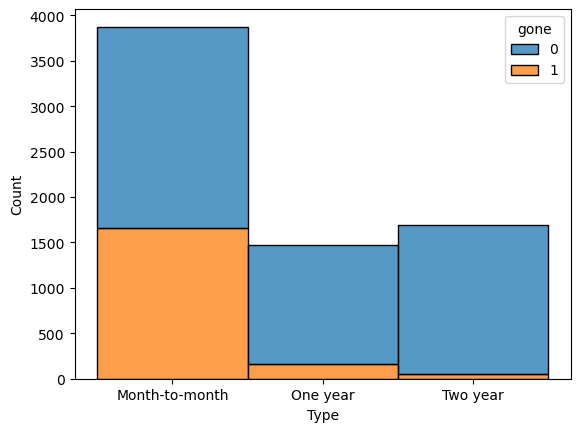

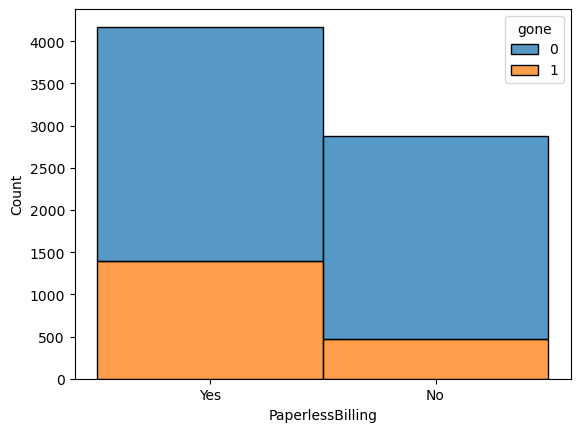

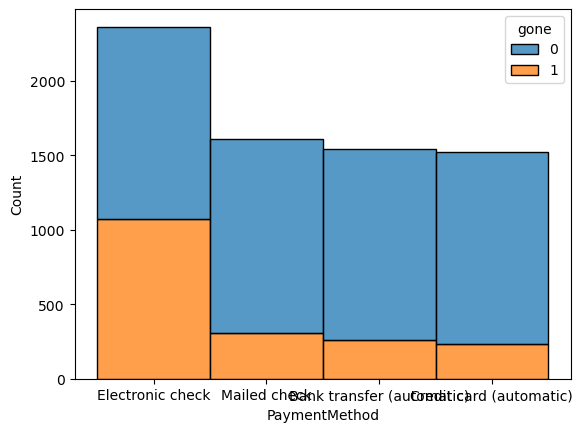

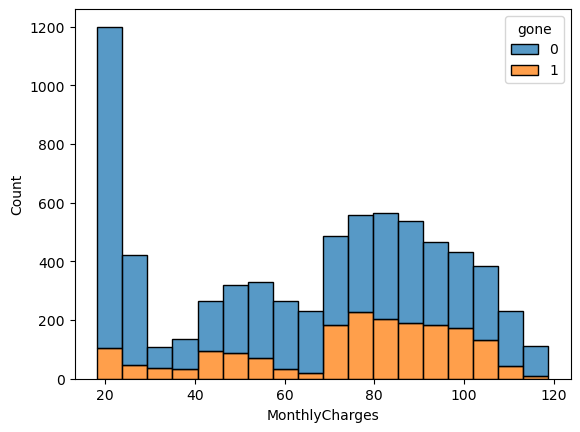

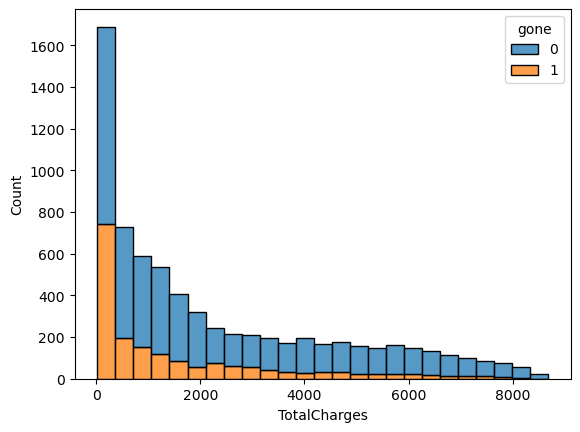

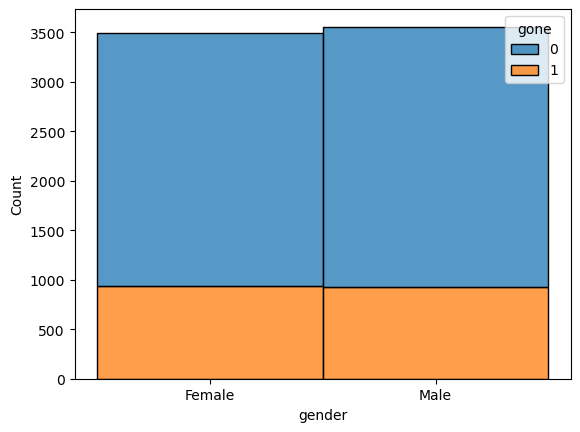

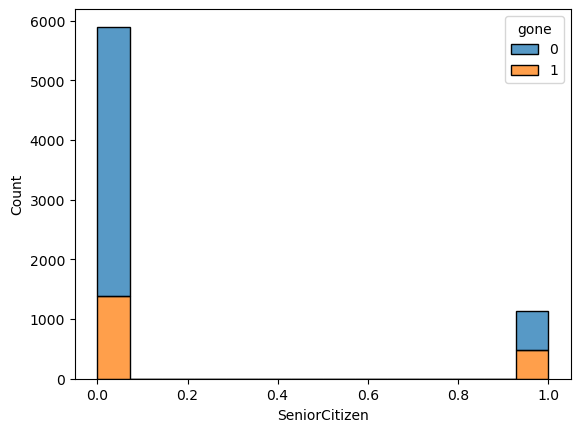

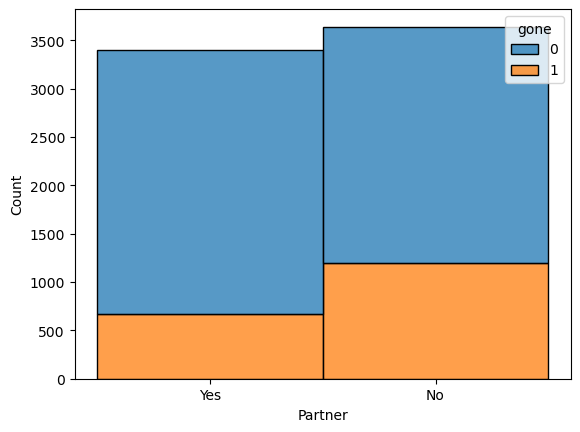

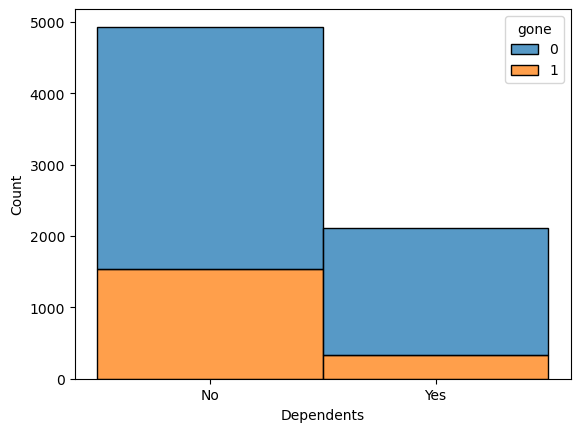

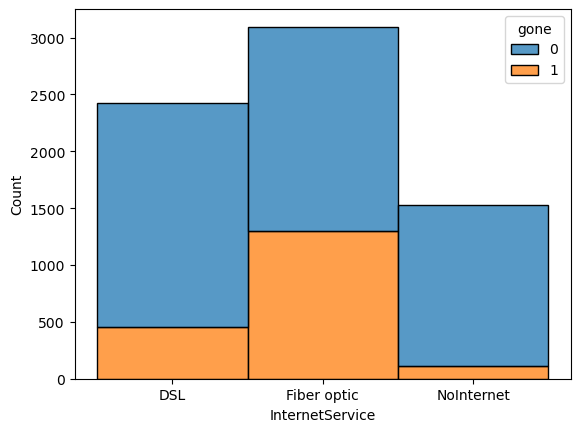

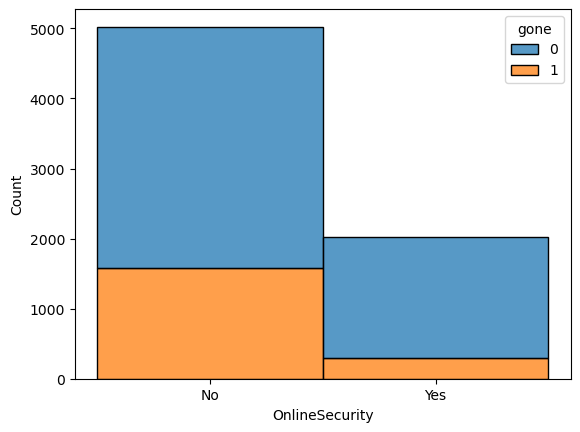

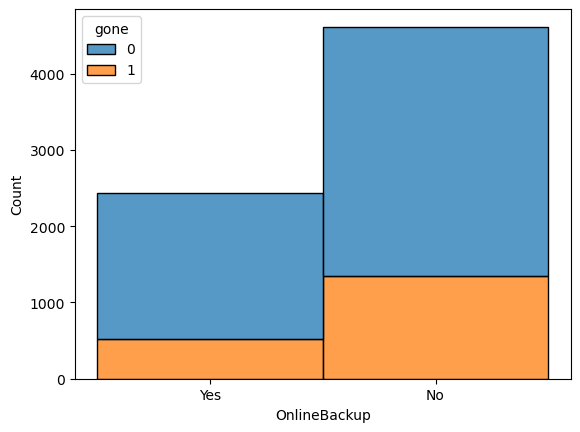

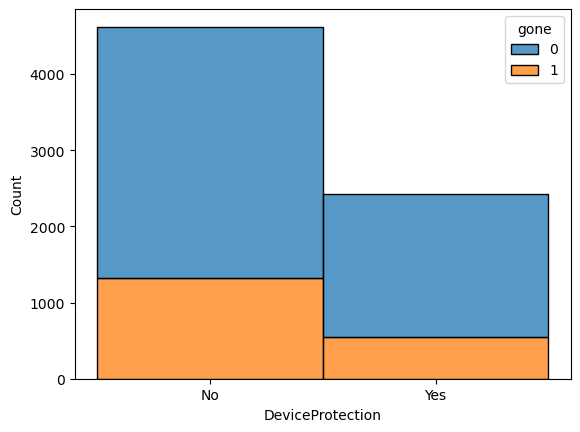

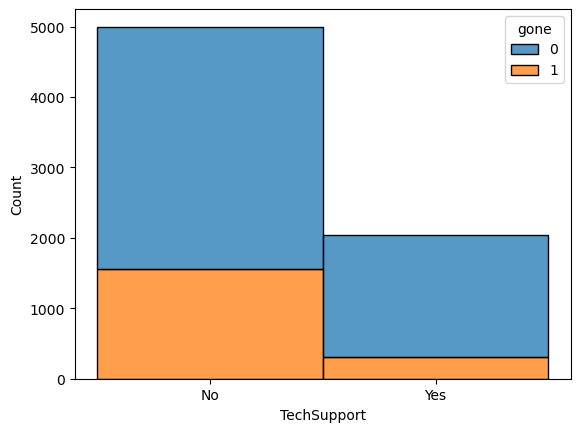

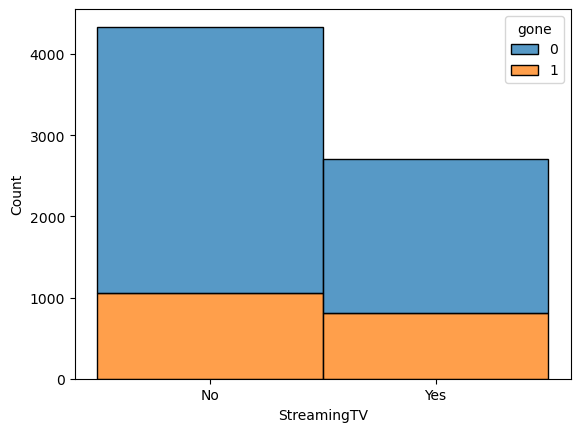

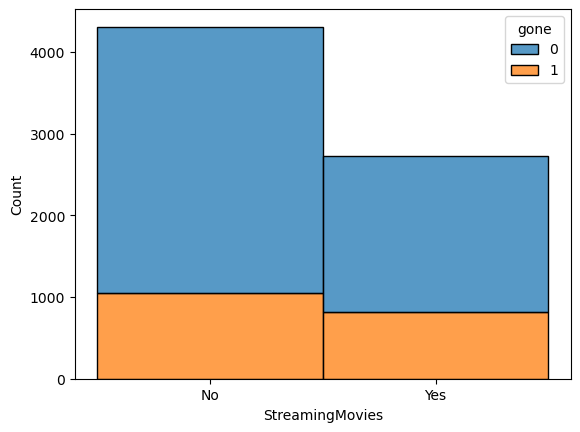

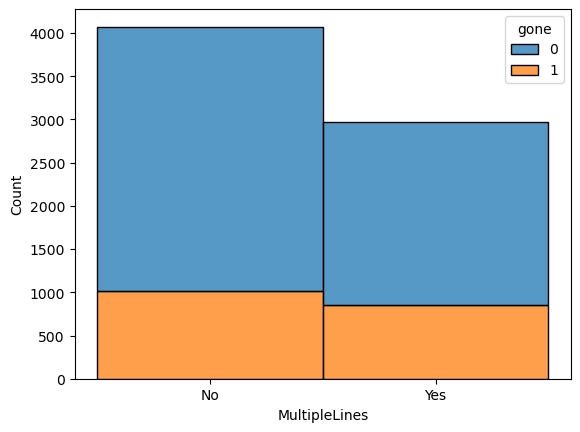

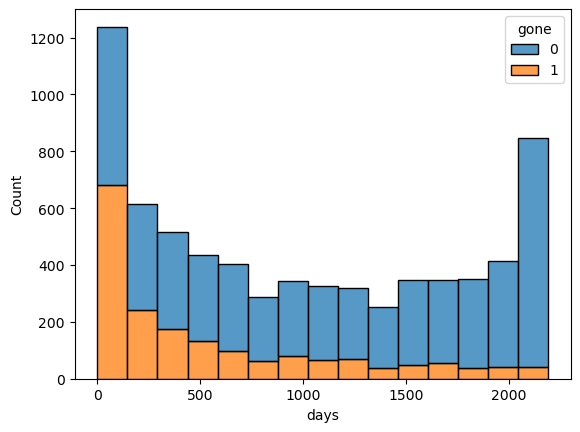

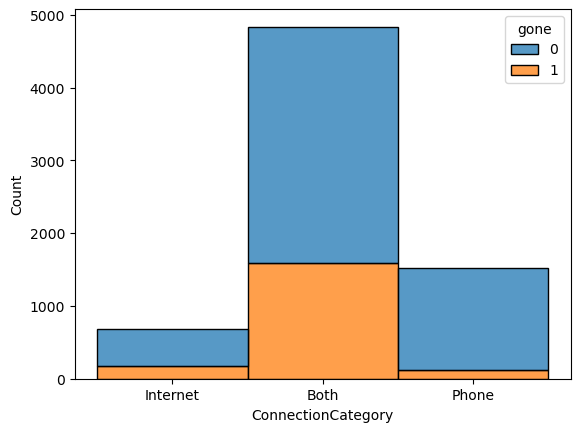

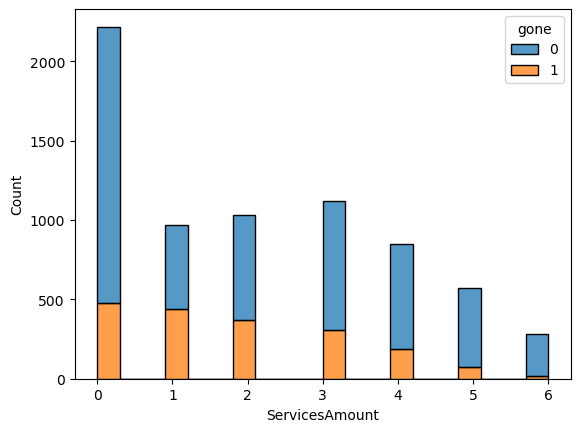

In [40]:
for column in columns[1:21]:
    sns.histplot(data, x = column, hue = 'gone', multiple = 'stack')
    plt.show();

Ушедших пользователей около четверти (26.5%), то есть в данных присутствует определённый дисбаланс классов.

При этом мы видим, что 
 - по диаграмме `Type`: уходит половина выбирающих ежемесячные платежи и единичные проценты остальных пользователей;
 - по диаграмме `PaymentMethod`: уходит половина выбирающих электронные чеки и около 10% выбирающих другие типы платежей;
 - по диаграмме `MonthlyCharges`: уходит чуть меньше половины тех, кто платит от 70 до 110 долларов в месяц и единицы среди тех, кто платит меньше;
 - по диаграмме `TotalCharges`: уходит около половины тех, кто заплатил еньше 400 долларов и гораздо меньше в оставшихся категориях;
 - по диаграмме `days`: больше всего уходит новых пользователей.

### Матрица корреляций
Мы построим матрицу фи-корреляций, объединяющую в себе коэффициенты корреляции для нормально распределенных количественных признаков (Пирсона), коэффициент ранговой корреляции Спирмена и коэффициент корреляции Крамера. 

Мы видим, что столбец `gender` действительно имеет практическую нулевой коэффициент корреляции со всеми остальными столбцами, а у столбца `gone` наибольшие корреляции с `days`, `PaymentMethod`, `MonthlyCharges`, `PaperlessBilling`, `TotalCharges`. Это в целом совпадает с выводами, полученными по визуальному изучению гистограмм.

Столбец `TotalCharges` имеет естественную большую корреляцию с `days`, а `MonthlyCharges` - с `InternetServices` и столбцами, связанными с конкретными интернет-услугами. 

In [41]:
phik_overview = data[columns[1:22]].phik_matrix() 

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'days', 'ServicesAmount', 'gone']


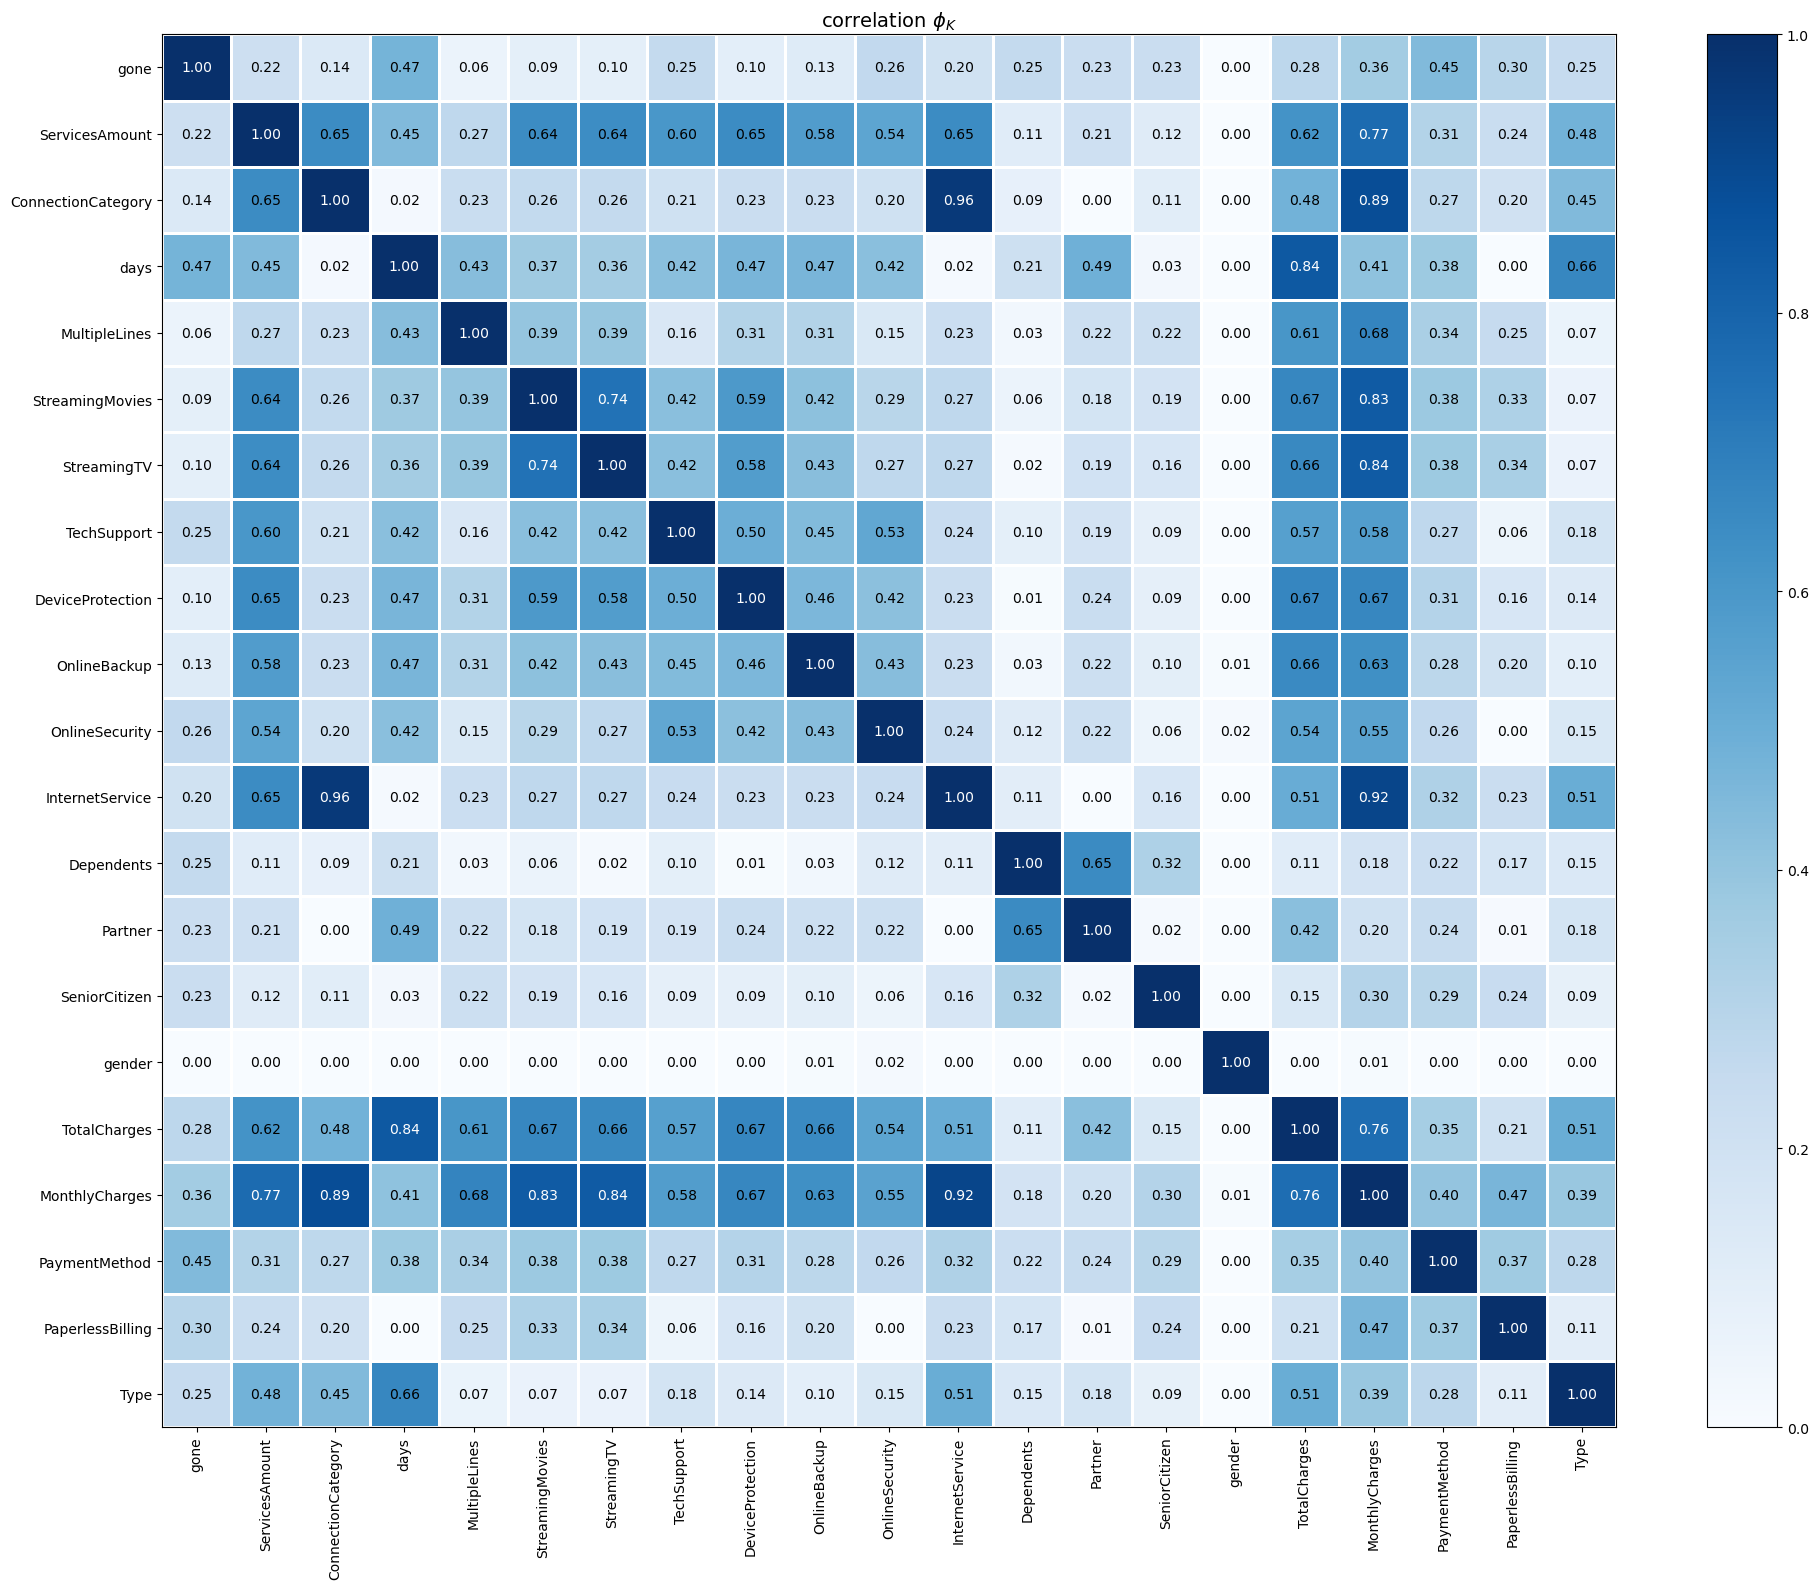

In [42]:
plot_correlation_matrix(phik_overview.values, 
                       x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(20, 16))
plt.tight_layout()

### Подготовка признаков
- удаляем ненужные столбцы, в том числе столбец `gender`
- формируем featues и target
- делим выборку на тренировочную и тестовую части в соотношении 75:25
- нормируем количественные признаки (понадобится при построении логарифмической регрессии) при помощи StandardScaler
- кодируем качественные признаки с помощью OneHotEncoder

In [43]:
features =  data.drop(['customerID', 'gone', 'gender'], axis = 1)
target = data['gone']

In [44]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=160123)

print(target_train.shape, target_test.shape)
print(features_train.shape, features_test.shape)

(5282,) (1761,)
(5282, 19) (1761, 19)


#### Подготовка количественных признаков
Поскольку мы будем рассматривать модель логистической регрессии, то произведём масштабирование количественных признаков.

In [45]:
quant_features =  ['MonthlyCharges', 'TotalCharges', 'days', 'ServicesAmount']
scaler = StandardScaler().fit(features_train[quant_features])
features_train[quant_features] = scaler.transform(features_train[quant_features])
features_test[quant_features] = scaler.transform(features_test[quant_features])

#### Подготовка качественных признаков

In [46]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Dependents', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                'MultipleLines', 'ConnectionCategory', 'Partner']

In [47]:
features_ohe_train = features_train.copy()
features_ohe_test = features_test.copy()

In [48]:
ohe = OneHotEncoder(drop='first')
ohe.fit(features_ohe_train[cat_features])
try:
    ohe_columns = ohe.get_feature_names_out(cat_features)
except:
    ohe_columns = ohe.get_feature_names(cat_features)
features_cat_train = pd.DataFrame(ohe.transform(features_ohe_train[cat_features]).toarray(), columns=ohe_columns,
                                 index=features_ohe_train.index)
features_ohe_train = features_cat_train.join(features_train[quant_features])

features_cat_test = pd.DataFrame(ohe.transform(features_ohe_test[cat_features]).toarray(), columns=ohe_columns,
                                 index=features_ohe_test.index)
features_ohe_test= features_cat_test.join(features_test[quant_features])

In [49]:
features_ohe_test.head().T

,5312,3455,1399,3732,5462
Type_One year,0.000000,0.000000,1.000000,0.000000,1.000000
Type_Two year,0.000000,0.000000,0.000000,1.000000,0.000000
PaperlessBilling_Yes,0.000000,1.000000,0.000000,1.000000,1.000000
PaymentMethod_Credit card (automatic),0.000000,0.000000,0.000000,0.000000,0.000000
PaymentMethod_Electronic check,0.000000,1.000000,0.000000,0.000000,0.000000
PaymentMethod_Mailed check,1.000000,0.000000,1.000000,0.000000,1.000000
SeniorCitizen_1,0.000000,0.000000,0.000000,0.000000,0.000000
Dependents_Yes,0.000000,0.000000,1.000000,1.000000,0.000000
InternetService_Fiber optic,0.000000,1.000000,0.000000,0.000000,0.000000
InternetService_NoInternet,0.000000,0.000000,1.000000,0.000000,0.000000


### Обучение моделей


In [50]:
rocs=[]
accs=[]

#### Дерево решений

In [51]:
dtc = DecisionTreeClassifier(random_state = 160123)
grid = {'min_samples_split': (2, 5), 'max_depth': (1,10)}
gdtc = GridSearchCV(dtc, param_grid=grid, scoring='roc_auc', n_jobs=-1)
gdtc.fit(features_ohe_train, target_train)
best_model_dtc = gdtc.best_estimator_


In [52]:
print('ROC_AUC (DecisionTreeClassifier):', gdtc.best_score_ )
rocs.append(gdtc.best_score_)

ROC_AUC (DecisionTreeClassifier): 0.8017316534560844


In [53]:
scores = cross_val_score(best_model_dtc, features_ohe_train, target_train, cv=5)
print('ACCURACY (DecisionTreeClassifier):', scores.mean())
acc=np.mean(scores)
accs.append(acc)

ACCURACY (DecisionTreeClassifier): 0.7989387130529514


#### Случайный лес

In [54]:
rfc = RandomForestClassifier(random_state = 160123)
grid = {'n_estimators': (1,5,1), 'max_depth': (10,20,2)}
grfc = GridSearchCV(rfc, param_grid=grid, scoring='roc_auc', n_jobs=-1)
grfc.fit(features_ohe_train, target_train)
best_model_rfc = grfc.best_estimator_

In [55]:
print('ROC_AUC (RandomForestClassifier):', grfc.best_score_)
rocs.append(grfc.best_score_)

ROC_AUC (RandomForestClassifier): 0.8224769078584998


In [56]:
scores = cross_val_score(best_model_rfc, features_ohe_train, target_train, cv=5)
acc=np.mean(scores)
accs.append(acc)
print('ACCURACY (RandomForestClassifier):', scores.mean())

ACCURACY (RandomForestClassifier): 0.7919334666437317


#### Логистическая регрессия

Из корреляционной матрицы мы можем заметить, что признак `InternetService` коррелируют с коэффициентом 0.96 с `ConnectionCategory`, а с  коэффициентом 0.92 с признаком `MonthlyCharges`. Кроме того,`TotalCharges` линейно зависит от `MonthlyCharges` и `days`, а `ServicesAmount` представляет собой сумму признаков, относящихся к конкретным интернет-услугам. Для избежания переобучения мы используем регуляризацию, прописывая параметр штрафа penalty="l2".

In [57]:
lr = LogisticRegression(random_state = 160123, class_weight = 'balanced', penalty="l2", solver='liblinear', max_iter = 100)
grid = {'C':(1,15)}
glr = GridSearchCV(lr, param_grid=grid, scoring='roc_auc', n_jobs=-1)
glr.fit(features_ohe_train, target_train)
best_model_lr = glr.best_estimator_

In [58]:
probabilities=best_model_lr.predict_proba(features_ohe_train)
probabilities_one = probabilities[:,1]
print('ROC_AUC (LogisticRegression):', glr.best_score_)
rocs.append(glr.best_score_)

ROC_AUC (LogisticRegression): 0.8431662933770749


In [59]:
scores = cross_val_score(best_model_lr, features_ohe_train, target_train, cv=5)
acc=np.mean(scores)
accs.append(acc)
print('ACCURACY (LogisticRegression):', scores.mean())

ACCURACY (LogisticRegression): 0.7447958774117714


#### Стохастический градиентный спуск

In [60]:
sgdc = SGDClassifier(random_state = 12345, loss='modified_huber', penalty="l2", class_weight = 'balanced', max_iter = 1000)
grid = {}
gsgdc = GridSearchCV(sgdc, param_grid=grid, scoring='roc_auc', n_jobs=-1)
gsgdc.fit(features_ohe_train, target_train)
best_model_sgdc = gsgdc.best_estimator_


In [61]:
print('ROC_AUC (SGDClassifier):', gsgdc.best_score_)
rocs.append(gsgdc.best_score_)

ROC_AUC (SGDClassifier): 0.8016506947506288


In [62]:
scores = cross_val_score(best_model_sgdc, features_ohe_train, target_train, cv=5)
print('ACCURACY (SGDClassifier):', scores.mean())
acc=np.mean(scores)
accs.append(acc)

ACCURACY (SGDClassifier): 0.7025660459849201


#### CatBoost

In [62]:
cbc = CatBoostClassifier(cat_features=cat_features, verbose=False) 
grid = {'iterations': (140,150,10), 'depth': (6,12,2),  
        'learning_rate': (0.5, 0.9, 0.1)}
gcbc = GridSearchCV(cbc, param_grid=grid, scoring='roc_auc', n_jobs=-1)
gcbc.fit(features_train, target_train, verbose=False)
best_model_cbc = gcbc.best_estimator_


In [63]:
print('ROC_AUC (CatBoostClassifier):', gcbc.best_score_)
rocs.append(gcbc.best_score_)

ROC_AUC (CatBoostClassifier): 0.8876696748214172


In [64]:
scores = cross_val_score(best_model_cbc, features_train, target_train, cv=5)
print('ACCURACY (CatBoostClassifier):', scores.mean())

ACCURACY (CatBoostClassifier): 0.8392624208021559


In [65]:
accs.append(scores.mean())

#### LGBM Classifier

In [63]:
for feature in cat_features:
    features_train[feature] = features_train[feature].astype('category')
    features_test[feature] = features_test[feature].astype('category')

In [64]:
lgbmc = LGBMClassifier(n_estimators = 100, n_jobs=-1)
grid = {'n_estimators': (10,100,5), 'learning_rate': (0.5, 0.9, 0.1)}
glgbmc = GridSearchCV(lgbmc, param_grid=grid, scoring='roc_auc', n_jobs=-1)
glgbmc.fit(features_train, target_train, verbose=False)
best_model_lgbmc = glgbmc.best_estimator_

In [65]:
print('ROC_AUC (LGBM Classifier):', glgbmc.best_score_)
rocs.append(glgbmc.best_score_)

ROC_AUC (LGBM Classifier): 0.8888311754947094


In [66]:
scores = cross_val_score(best_model_lgbmc, features_train, target_train, cv=5)
print('ACCURACY (LGBM Classifier):', scores.mean())
accs.append(scores.mean())

ACCURACY (LGBM Classifier): 0.8432409477939279


In [69]:
glgbmc.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

### Подбор порога классификации
В плане предполагалось улучшить порог классификации для лучшей модели на тренировочной выборке, но мы не будем этого делать, поскольку метрика roc_auc не чувствительна к дисбалансу классов, в отличие от f1_score.

### ROC-кривая

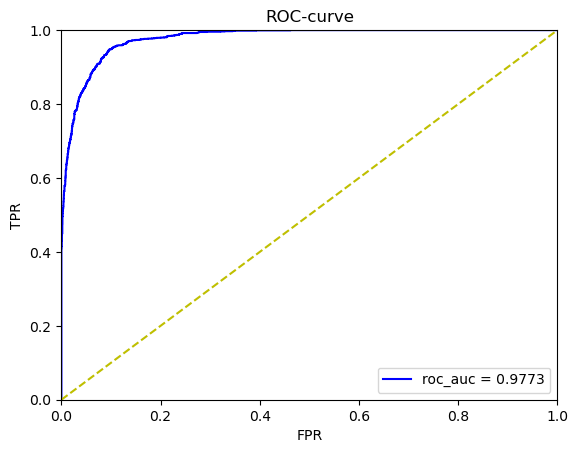

In [214]:
probabilities = best_model_lgbmc.predict_proba(features_train)
predictions = probabilities[:,1]
fpr, tpr, threshold = roc_curve(target_train, predictions)
roc_auc = auc(fpr, tpr)


plt.title('ROC-curve')
plt.plot(fpr, tpr, 'b', label = 'roc_auc = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'y--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

### Значимость признаков
Наиболее значимыми признаками оказались столбцы `days`, `MonthlyCharges`, `Type`, `TotalCharges`, что, в целом, совпадает с нашими предположениями исследовательского и корреляционного анализа.

In [195]:
rows = pd.Series(features_train.columns, index=range(len(features_train.columns)), name='features')

In [215]:
importances=pd.Series(best_model_lgbmc.feature_importances_, index=range(len(features_train.columns)), name='importances')

In [216]:
pd.DataFrame({'ohe_features':rows, 'importances':importances}).sort_values(by='importances', ascending=False)

,ohe_features,importances
16,days,1156
3,MonthlyCharges,589
4,TotalCharges,511
0,Type,98
18,ServicesAmount,73
5,SeniorCitizen,49
6,Partner,49
9,OnlineSecurity,49
7,Dependents,47
1,PaperlessBilling,47


### Вывод и итоговое тестирование для лучшей модели (LGBMClassifier)

Мы рассмотрели модели:
- случайный лес;

- дерево решений;

- логистическая регрессия;

- стохастический градиентный спуск SGDClassifier;

- бустинг с помощью CatBoostClassifier;

- бустинг с помощью LGBMClassifier;

Результаты метрик приведены в таблице ниже.

Самые удачные результаты показали модели, построенные на основе бустингов, при этом как по значению roc_auc, так и по значению accuracy 2 модели оказались практически идентичными (отличаются на тысячные доли). Лучшей оказалась модель бустинга с помощью библиотеки LGBM. 

In [198]:
result = pd.DataFrame(data = [['ROC_AUC'] + rocs,
                              ['Accuracy'] + accs],                              
                      columns = ['metric', 'DecisionTreeClassifier', 'RandomForestClassifier', 'LogisticRegression' , 'SGDClassifier',
                                'CatBoostClassifier', 'LightGBMClassifier'])

In [199]:
display(result)

,metric,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,SGDClassifier,CatBoostClassifier,LightGBMClassifier
0,ROC_AUC,0.801732,0.822477,0.843166,0.801651,0.887117,0.888831
1,Accuracy,0.798939,0.791933,0.744796,0.702566,0.842104,0.843241


Мы видим, что лучшая модель (LGBMClassifier) проходит итоговое тестирование (roc_auc > 0.91).

In [71]:
probabilities=best_model_lgbmc.predict_proba(features_test)
probabilities_one = probabilities[:,1]
print('ROC_AUC TEST (LGBMClassifier):', roc_auc_score(target_test, probabilities_one))



ROC_AUC TEST (LGBMClassifier): 0.9106264084242932


In [72]:
scores = cross_val_score(best_model_lgbmc, features_test, target_test, cv=5)
print('ACCURACY TEST (LGBM Classifier):', scores.mean())

ACCURACY TEST (LGBM Classifier): 0.8160024465619367


## Отчет по решению

В процессе решения задачи по прогнозированю оттока клиентом нами были рассмотрены 7043 договора о предоставлении услуг интернета и телефонии, информация о которых находилась в 4 файлах:
- `contract.csv` — информация о договоре (7043 строки);
- `personal.csv` — персональные данные клиента (7043 строки);
- `internet.csv` — информация об интернет-услугах (5517 строк);
- `phone.csv` — информация об услугах телефонии (6361 строка).

В целом мы следовали намеченному плану, но могли изменить порядок выполнения пунктов внутри отдельного раздела, кроме того, некоторые пункты были выполнены иначе, чем планировалось.


### Основные шаги
#### Разведочный и исследовательский анализ данных
На первом этапе мы проверили отдельно каждый файл на наличие дубликатов и объединили данные в общий датасет `data`, используя в качестве ключа поле `customerID` - идентификатор заключившего договор пользователя. При этом при объединении таблиц `contract` и `personal` мы использовали метод merge с параметром how='inner', а дополнительно объединяя их с таблицами `internet` и `phone` - метод merge с параметром how='outer'.

Столбцы таблицы `data` содержали:
- уникальный идентификатор доровора `customerID`
- столбцы, содержащие категориальные данные: `Type`,  `PaperlessBilling`, `PaymentMethod`, `gender`, `SeniorCitizen`, `Partner`, `Dependents`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines`
- стобцы, содержащие данные, относящиеся к дате: `BeginDate`, `EndDate`
- столбцы, содержащие количественные переменные: `MonthlyCharges`, `TotalCharges`

Мы отдельно работали с категориальными, количественными данными, а также данными, содержащими дату и время.

Для поиска аномалий в категориальных данных методом unique() мы рассмотрели уникальные значения в каждом из категориальных столбцов, аномалии не были обнаружены. 

Работая с датой и временем мы сформировали новый столбец `EndDateFill`, значение в котором равно значению в столбце `EndDate` там, где дата известна, либо '2020-02-01' там, где договор действующий. Данные во всех столбцах изначально были типа 'object', мы перевели их с помощью функции pd.to_datetime в формат datetime. Кроме того, мы создаем новый столбец `days` с количеством дней договора c помощью функции np.timedelta64.







Мы добавили ещё несколько новых столбцов-признаков:
 - `ConnectionCategory`, который принимает значение `Internet` для тех пользователей, кто используют только интернет, `Phone` --- для тех, кто пользуется только телефонией и `Both` - для тех, кто использует обе услуг
 - `ServicesAmount`, которых  показывает количество подключенных интернет услуг (до этого мы заполнили пропуски в столбцах `OnlineSecurity`,`OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` значениями `No`, поскольку пользователи не пользуются соответствующими услугами).

Заполняя оствашиеся пропуски в категориальных переменных, мы заполнили:
- пропуски в столбце `InternetService` значением-заглушкой `NoInternet`
- в столбце `MultipleLines` значением `No`, поскольку пользователь не пользуется данной услугой 

Перейдя к работе с количественными признаками, мы обнаружили некоторые проблемы и аномалии:
- столбец `TotalCharges` имел тип object, причем имелись проблемы с переводом в числовой формат из-за того, что в 11 ячейках стояли пробелы
- в 11 ячейках созданного столбца `days` значения равнялись нулю (эти строки соответствовали пользователям, которые заключили контракт в точности 1 февраля 2020 года)

Аномалии в двух столбцах совпадали, мы заполнили значения-пробелы столбца `TotalCharges` значениями из `MonthlyCharges`, после чего изменили тип данных столбца `TotalCharges` на числовой.

Исследовав количественные столбцы методом describe() после заполнения предобработки мы снова не заметили аномалий.
Таким образом, для обучения моделей в нашем распоряжении оказалось 7043 строки данных без пропусков.

На заключительном этапе предобработки мы удалили столбцы `BeginDate`, `EndDate`, `EndDateFill`.

Перед тем как приступить к построению моделей мы изучили распределение данных. Для этого:
 - мы построили  графики с наложенными гистограммами распределения признаков среди всех пользователей и среди ушедших попутно изучив распределения категориальных и количественных признаков. В результате мы визуально можем наблюдать, то распределения всех пользователей и ушедших практически полностью совпадают в столбце `gender` и в некоторых других столбцах. В то же время в столцах `Type`, `PaymentMethod`, `MonthlyCharges`, `TotalCharges`, `days`, `SeniorCitizen` расределения отличаются значительно.
 - мы построили матрицу фи-корреляций, из которой увидели, что столбец `gender` действительно имеет околонулевой коэффициент корреляции со всеми остальными столбцами, а у столбца `gone` наибольшие корреляции с `days`, `PaymentMethod`, `MonthlyCharges`, `PaperlessBilling`, `TotalCharges`.

#### Подготовка данных перед обучением моделей

Мы рамках подготовки данных перед обучением мы проделали следующие шаги:
- удалили столбцы `customerID` и `gender`
- сформировали целевую переменную target как столбец `gone` датасета и столбец зависимых признаков featues как остальные столбцы датасета
- **разделили выборки featues и target на тренировочную и тестовую части в соотношении 75:25**
- пронормировали количественные признаки при помощи StandardScaler
- закодировали качественные признаки с помощью OneHotEncoder

Таким образом, **для обучени всех моделей мы использовали**:
- количественные признаки `MonthlyCharges`, `TotalCharges`, `days`, `ServicesAmount`
- категориальные признаки `Type`, `PaperlessBilling`, `PaymentMethod`, `SeniorCitizen`, `Dependents`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines`, `ConnectionCategory`, `Partner`

#### Рассмотренные модели и результаты обучения

При обучении моделей мы подбирали гиперпараметры с помощью инструмента GridSearchCV, попутно проводя кросс-валидацию. В качестве метрики качества мы рассматривали roc_auc, а также accuracy как дополнительную метрику. Метрику roc_auc мы получали с помощью атрибута GridSearchCV best_scores_, а метрику accuracy с помощью cross_val_score c cv=5. Лучшую модель мы выбирали на основе метрик, полученных на тренировочной выборке.

Мы рассмотрели следующие модели с соответствующими гиперпараметрами:
- случайный лес, параметры: {'min_samples_split': (2, 5), 'max_depth': (1,10)};

- дерево решений, параметры: {'n_estimators': (1,5,1), 'max_depth': (10,20,2)};

- логистическая регрессия с регулярризацией (penalty="l2", solver='liblinear') , параметры: {'C':(1,15)};

- стохастический градиентный спуск SGDClassifier с параметрами loss='modified_huber', penalty="l2", class_weight = 'balanced', max_iter = 1000 без подбора гиперпараметров, только с кросс-валидацией; 

- бустинг с помощью CatBoostClassifier, параметры {'iterations': (140,150,10), 'depth': (6,12,2), 'learning_rate': (0.5, 0.9, 0.1)};

- бустинг с помощью LGBMClassifier, {'n_estimators': (10,100,5), 'learning_rate': (0.5, 0.9, 0.1)} ;

Результаты тесторования моделей можно посмотреть в таблице ниже:


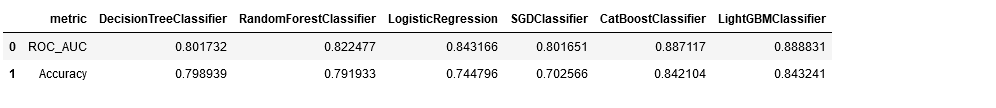


Кроме того, для лучшей модели мы построили roc-кривую и посмотрели список наиболее значимых признаков с помощью атрибута feature_importances_. Наиболее значимыми признаками оказались столбцы `days`, `MonthlyCharges`, `Type`, `TotalCharges`, что совпало предположениями на этапе предобработки.

### Лучшая модель и результаты итогового тестирования

Самые удачные результаты показали модели, построенные на основе бустингов, при этом как по значению roc_auc, так и по значению accuracy 2 модели оказались практически идентичными.

**Лучшей моделью** оказалась модель **LGBMClassifier c гиперпараметрами 'learning_rate'= 0.1, 'n_estimators'= 100.**


**Метрики** лучшей модели **на тестовой выборке**:

   **ROC_AUC = 0.91**
   
   **Accuracy = 0.81**
    

### Особенности выполнения проекта, отличия от плана

**Ключевым этапом** выполнения проекта оказалась **предобработка данных**. Изначально проект был выполнен согласно составленному плану, но полученная метрика roc_auc оказалась недостаточно высокой, что **стало основной сложностью работы**. Для улучшения метрик предобработка данных была проведена заново. В частности, на этапе предобработки мы в отличие от плана:
- вычисляли период действия договора  в днях, а не в месяцах
- сохранили столбец `TotalCharges` 
- сгенерировали ещё столбцы-признаки: тип услуги (телефония/интернет/обе) и количество подключенных интернет-услуг.

Также потребовалось грамотно заполнить пропуски.

Этап подготовки данных для обучения, а также обучения моделей был выполнен согласно плану и не составил сложностей при выполнении. **Вторым по значимости** после предобработки этапом, позволившим получить высокое значение метрики roc_auc, стало **использование моделей бустингов**. 

В плане предполагалось улучшить порог классификации для лучшей модели на тренировочной выборке, но мы отказались от этого пункта, поскольку метрика roc_auc не чувствительна к дисбалансу классов, в отличие от f1_score.

Изначально мы ожидали, что в процессе выполнения проекта мы сможем выявить группу клиентов, склонных к уходу (например, новые клиенты или клиенты-пенсионеры), но при выполнении оказалось, что факторов, влияющие на уход, несколько и они, судя по всему, дополняют друг друга. Но если на этапе предобработки мы смогли только заметить, что склонны к уходу клиенты недавнопришедшие клиенты с помесячной оплатой, то после построения моделей мы смогли уже предсказывать уход клиента с достаточной точностью. Таким образом, построенная нами модель машинного обучения существенно улучшила возможности аналитики и прогнозирования.